### Time Series Forecasting
#### Objective : To create a time series regression model to forecast the total energy use of appliances in a low energy building. 

#### Context: 
This data set contains the energy consumption values of electrical appliances in a building, recorded at 10 minute intervals for around 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

#### The data set has been remodified to contain the only 1 column of energy use for the appliances and has been upsampled to give only hourly readings instead of every 10 min. The index has the respective date with time. The energy consumption is recorded for approx. 4.5 months (11.01.2016 17:00:00 – 27.05.2016 18:00:00) ####

#### Datasource : UCI ML Repository https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction ####

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import os

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
%matplotlib inline
plotsize = (13, 5)
pd.options.display.float_format = '{:,.2f}'.format
pd.plotting.register_matplotlib_converters()

### Reading the files

In [3]:
path = './'
df = pd.read_csv(os.path.join(path,'energydata_complete_UCI.csv'))

### Preprocessing and Data Cleaning ###

In [4]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.60,19.20,44.79,19.79,44.73,19.00,...,17.03,45.53,6.60,733.50,92.00,7.00,63.00,5.30,13.28,13.28
1,2016-01-11 17:10:00,60,30,19.89,46.69,19.20,44.72,19.79,44.79,19.00,...,17.07,45.56,6.48,733.60,92.00,6.67,59.17,5.20,18.61,18.61
2,2016-01-11 17:20:00,50,30,19.89,46.30,19.20,44.63,19.79,44.93,18.93,...,17.00,45.50,6.37,733.70,92.00,6.33,55.33,5.10,28.64,28.64
3,2016-01-11 17:30:00,50,40,19.89,46.07,19.20,44.59,19.79,45.00,18.89,...,17.00,45.40,6.25,733.80,92.00,6.00,51.50,5.00,45.41,45.41
4,2016-01-11 17:40:00,60,40,19.89,46.33,19.20,44.53,19.79,45.00,18.89,...,17.00,45.40,6.13,733.90,92.00,5.67,47.67,4.90,10.08,10.08


> The column 'Appliances' represents the energy consumption values of the appliances

In [5]:
df.shape

(19735, 29)

#### Statistical summary of appliances energy consumption

In [6]:
df['Appliances'].describe().T

count   19,735.00
mean        97.69
std        102.52
min         10.00
25%         50.00
50%         60.00
75%        100.00
max      1,080.00
Name: Appliances, dtype: float64

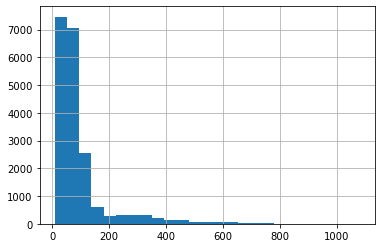

In [7]:
df['Appliances'].hist(bins=25);

> We need normal distribution instead of uniform for a stationary TS. Here we can see that its not perfectly normal but positively skewed

In [8]:
df['date'].dtype

dtype('O')

#### Change datetime from 'object' to 'Datetime64' format

In [9]:
df['date'] = pd.to_datetime(df['date'])

#### Creating a new Dataframe for calculating the energy consumption of the appliances only

In [10]:
df_A = df[['date','Appliances']]
df_A.set_index('date',inplace=True)
df_A.head()

,Appliances
date,
2016-01-11 17:00:00,60
2016-01-11 17:10:00,60
2016-01-11 17:20:00,50
2016-01-11 17:30:00,50
2016-01-11 17:40:00,60


In [11]:
df_A = df_A[df_A.index > '2016-01-11 23:50:00']
df_A.head(7)

,Appliances
date,
2016-01-12 00:00:00,40
2016-01-12 00:10:00,30
2016-01-12 00:20:00,40
2016-01-12 00:30:00,50
2016-01-12 00:40:00,310
2016-01-12 00:50:00,380
2016-01-12 01:00:00,380


> Cleaning the dataframe df_A : The entries for the date 11.01.2016 will be removed as they start only from 17:00:00 hours

### Feature Engineering

#### For ease of calculations, the time intervals will be upscaled from 10 minute to hourly intervals with the mean

In [12]:
## Upsampling 
df_B = df_A.resample('H').sum()
print('hourly resampled data \n')
df_B.head()

hourly resampled data 



,Appliances
date,
2016-01-12 00:00:00,850
2016-01-12 01:00:00,1010
2016-01-12 02:00:00,270
2016-01-12 03:00:00,210
2016-01-12 04:00:00,270


In [13]:
df_B.shape

(3283, 1)

### Checking for Stationarity

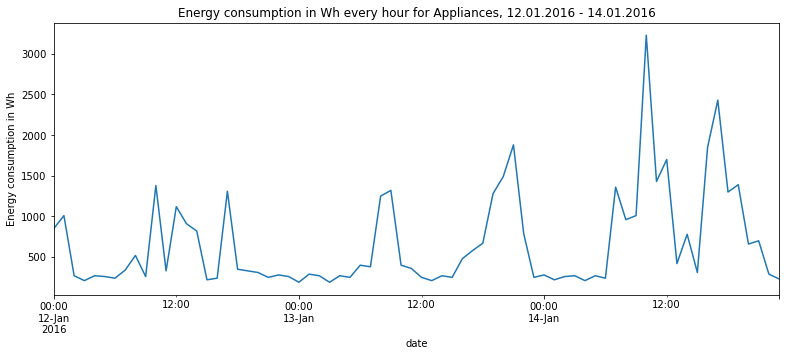

In [14]:
n = 24
df_B['Appliances'][:3*n].plot(figsize=plotsize, title='Energy consumption in Wh every hour for Appliances, 12.01.2016 - 14.01.2016');
plt.ylabel('Energy consumption in Wh');

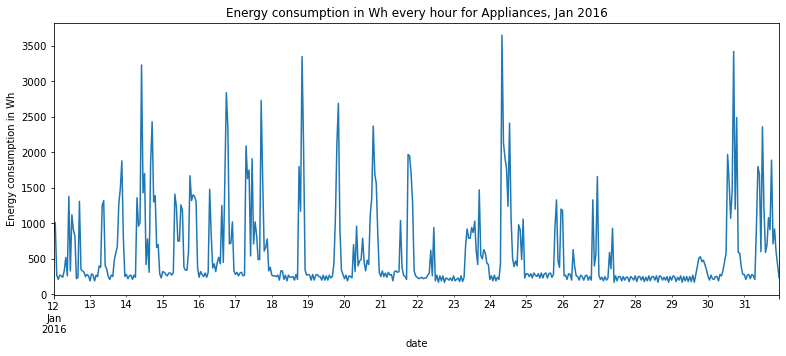

In [15]:
df_B['Appliances']['2016-01'].plot(figsize=plotsize, title='Energy consumption in Wh every hour for Appliances, Jan 2016')
plt.ylabel('Energy consumption in Wh');

> From the above two plots, it can be seen that :   
> __• The Variance is not constant → non-stationary TS   
  • Trend seems to be constant    
  • There seems to be a seasonality of around 24 h__    

It is more clear that variance varies from day to day. On close observation, one can see that around 12:00 noon time everyday, there are spikes in energy consumption. __Hence seasonality is approx. 24__

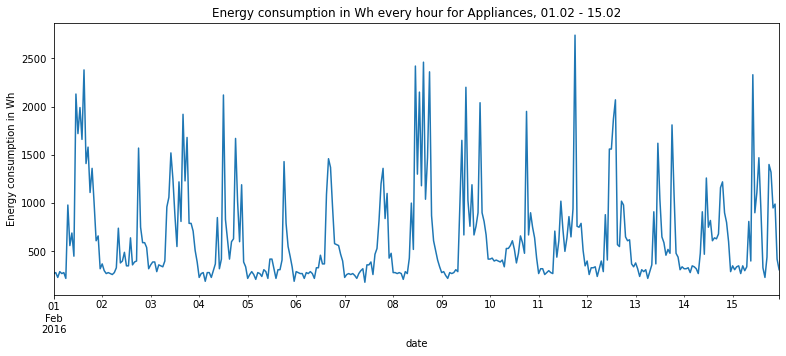

In [16]:
df_B['Appliances']['2016-02-01':'2016-02-15'].plot(figsize=plotsize, title='Energy consumption in Wh every hour for Appliances, 01.02 - 15.02')
plt.ylabel('Energy consumption in Wh');

#### Feature Engineering
#### Log transformation to convert the TimeSeries into a stationary TimeSeries (since the variance changes a lot)

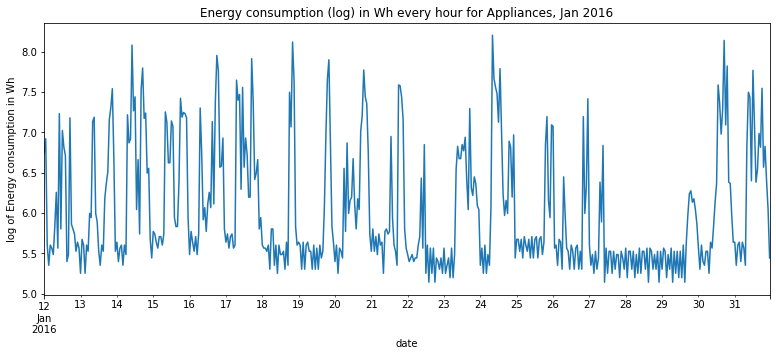

In [17]:
df_B['log_a'] = np.log1p(df_B['Appliances'])
df_B['log_a']['2016-01'].plot(figsize=plotsize, title='Energy consumption (log) in Wh every hour for Appliances, Jan 2016')
plt.ylabel('log of Energy consumption in Wh');

#### Log plots of the month of March to see for seasonalities

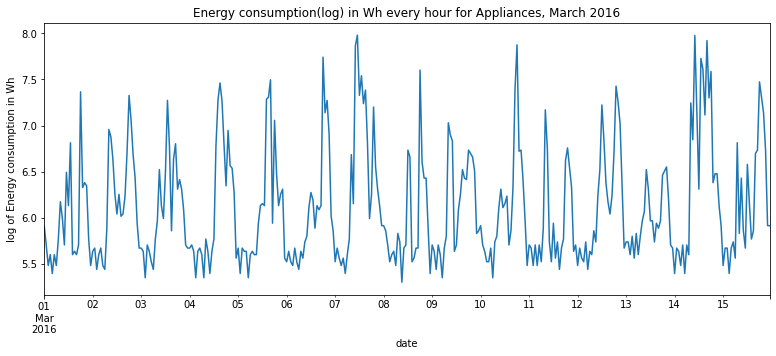

In [18]:
df_B['log_a']['2016-03-01':'2016-03-15'].plot(figsize=plotsize, title='Energy consumption(log) in Wh every hour for Appliances, March 2016')
plt.ylabel('log of Energy consumption in Wh');

> Somewhat of a constant variance than before

### Decomposition to separate the Trend, Seasonality and the Residual
> frequency = 24

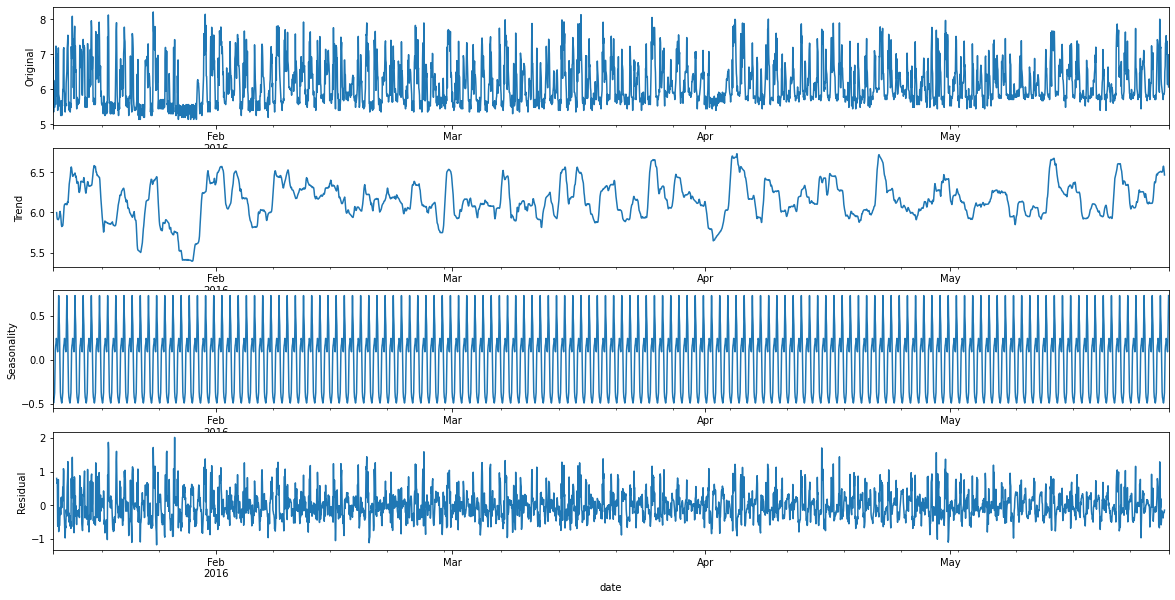

In [19]:
fig, ax = plt.subplots(nrows=4,figsize=(20,10))
sd = seasonal_decompose(df_B['log_a'],period=24)
sd.observed.plot(ax=ax[0],ylabel='Original')
sd.trend.plot(ax=ax[1],ylabel='Trend')
sd.seasonal.plot(ax=ax[2],ylabel='Seasonality')
sd.resid.plot(ax=ax[3],ylabel='Residual');

> Residual seems to be like white noise → reassuring that it is now a stationary TS

#### Histogram of the log transformed data to recheck for stationarity

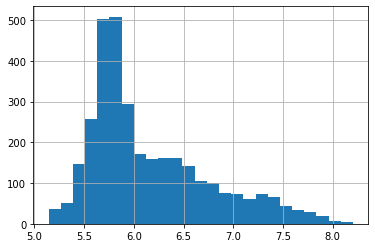

In [20]:
df_B['log_a'].hist(bins=25);

#### Autocorrelation and Partial Autocorrelation 

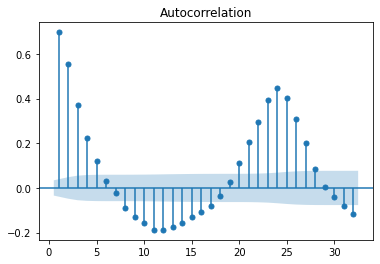

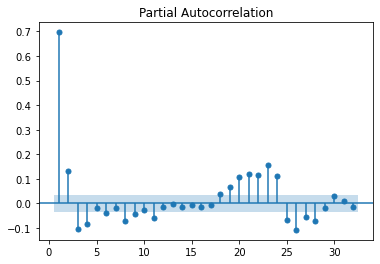

In [21]:
sm.tsa.graphics.plot_acf(df_B['log_a'],lags=32,zero=False)
sm.tsa.graphics.plot_pacf(df_B['log_a'],lags=32,zero = False);

> **Autocorrelation:** One can see that there is a strong autocorrelation and the seasonality is at lag 24. From here one can assume the __"q" = 5__ 

> **Partial-Autocorrelation:** One can see that there is an autocorrelation for 2 lags and then the values reduce to zero fast. Hence one can assume __"p" = 2__


#### Dickey-Fuller Test
> Null Hypothesis is that unit root is present, rejection of null hypothesis means likely stationary. For this test, one needs to take the lag difference of 24

In [22]:
df_B['lag_24'] = df_B['log_a'].shift(24)
df_B['seasonal_diff'] = df_B['log_a'] - df_B['lag_24']

In [23]:
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    plt.grid()
    plt.show(block=False)

Test Statistic           -12.92
p-value                    0.00
Lags Used                 26.00
Observations Used      3,232.00
Critical Value (1%)       -3.43
Critical Value (5%)       -2.86
Critical Value (10%)      -2.57
dtype: float64


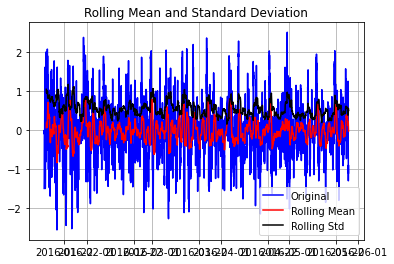

In [24]:
dftest(df_B['seasonal_diff'].dropna())

> __One sees that the p-value < 0.05. Hence Null-hypothesis is rejected and it is stationary__

#### Splitting the data into chunks
> Since the data has approx. 135 days, it is split into 13 chunks with each chunk of 10 days(240 ticks) time interval approx.

In [25]:
chunkm = []
chunkv = []
i=0
for n in range(13):
    j=i+240
    if n==12:
        j=df_B.shape[0]
    chunkm.append(np.round_(np.mean(df_B['log_a'].iloc[i:j]),decimals=3))
    chunkv.append(np.round_(np.var(df_B['log_a'].iloc[i:j]),decimals=3))
    i=j

print("chunks:")
print("Mean: \n", chunkm)
print("Var: \n", chunkv)

chunks:
Mean: 
 [6.174, 5.884, 6.224, 6.195, 6.123, 6.097, 6.201, 6.193, 6.155, 6.165, 6.202, 6.1, 6.223]
Var: 
 [0.58, 0.483, 0.419, 0.361, 0.348, 0.366, 0.395, 0.298, 0.373, 0.318, 0.332, 0.199, 0.298]


> Here also one can see that the mean and variance of each chunk remain almost constant.    
Hence it can be concluded that the __Time Series is stationary__

### Forecasting
Since the data apparently has seasonality and trend, Sarimax model with 3 different variations of the parameters (p,d,q)(P,D,Q,S) would be used. For the 3rd Model, the auto-Arima model is run to find the optimum parameters model.    

|Model|Name|(p,d,q)|(P,D,Q)|Seasonality S|
|---|---|---|---|---|
|1|Sarimax|(2,0,0)|(0,1,0)|24|
|2|Sarimax|(2,0,0)|(0,1,5)|24|
|3|Auto-arima|(2,0,0)|(2,1,0)|24|

**Error Metric** : Mape = Abs(actual values – forecast) / sum(actual values)

#### User-defined Functions

In [26]:
#Defining an error metric to see out of sample accuracy
def mape(model_name,horizon):
    fcst = []
    actual = []
    date = []
    fcst = df_B[-horizon:][model_name].values
    actual = df_B[-horizon:]['log_a'].values
    date = df_B.index[-horizon:]
    df_cv = pd.DataFrame({'fcst':fcst,'actual':actual},index=date)
    mape_ = abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()
    print('The mean error for Model {} is : {:.4f}'.format(model_name,mape_))

In [27]:
# define helper plot function for visualization
def plots(data, lags=None):
    fig, ax = plt.subplots(1,3)
    ax[0].plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=ax[1], zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=ax[2], zero = False)
    sns.despine()
    #plt.show()
    plt.tight_layout()

In [28]:
# Function to predict with the Auto-Arima model
def future_preds_df(model,series,num_hours):
    pred_first = series.index.max()+relativedelta(hours=1)
    pred_last = series.index.max()+relativedelta(hours=num_hours)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'H')
    vals = model.predict(n_periods = num_hours)
    return pd.DataFrame(vals,index = date_range_index)

### Splitting the data into train and test sets
Splitting of data into train and test set with test set = last 5 days = 120 hours

In [29]:
y_train = pd.Series(df_B['log_a'][:-120])
y_test = pd.Series(df_B['log_a'][-120:])
print('No of observations in y_train',y_train.shape)
print('No of observations in y_test',y_test.shape)

No of observations in y_train (3163,)
No of observations in y_test (120,)


### Model 1 : Sarimax (2,0,0)(0,1,0,24)
From PACF Model, one can see that p=2 and from ACF plot, that q=5. But since q is too high, just p=2 is chosen and q=0.   
Seasonality = 24 hours.

In [30]:
sar1 = sm.tsa.statespace.SARIMAX(y_train, 
                                order=(2,0,0), 
                                seasonal_order=(0,1,0,24), 
                                trend='c').fit()
sar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              log_a   No. Observations:                 3163
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 24)   Log Likelihood               -2422.702
Date:                            Fri, 21 May 2021   AIC                           4853.403
Time:                                    10:27:05   BIC                           4877.610
Sample:                                01-12-2016   HQIC                          4862.090
                                     - 05-22-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.009      0.068      0.946      -0.018       0.019
ar.L1          0.4171      0.013     32.343      0.000       0.392       0.442
ar.L2          0.2317      0.013     17.338      0.000       0.205       0.258
sigma2         0.2741      0.005     57.500      0.000       0.265       0.283
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               701.13
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> __AIC score = 4853.403__

#### Plot residuals

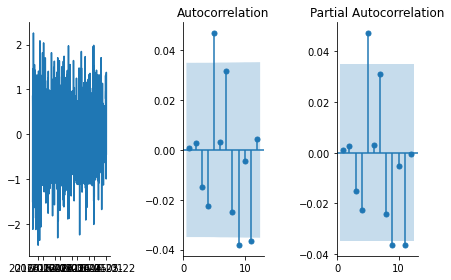

In [31]:
plots(sar1.resid[sar1.loglikelihood_burn:],lags=12);

#### Plot residual diagnostics

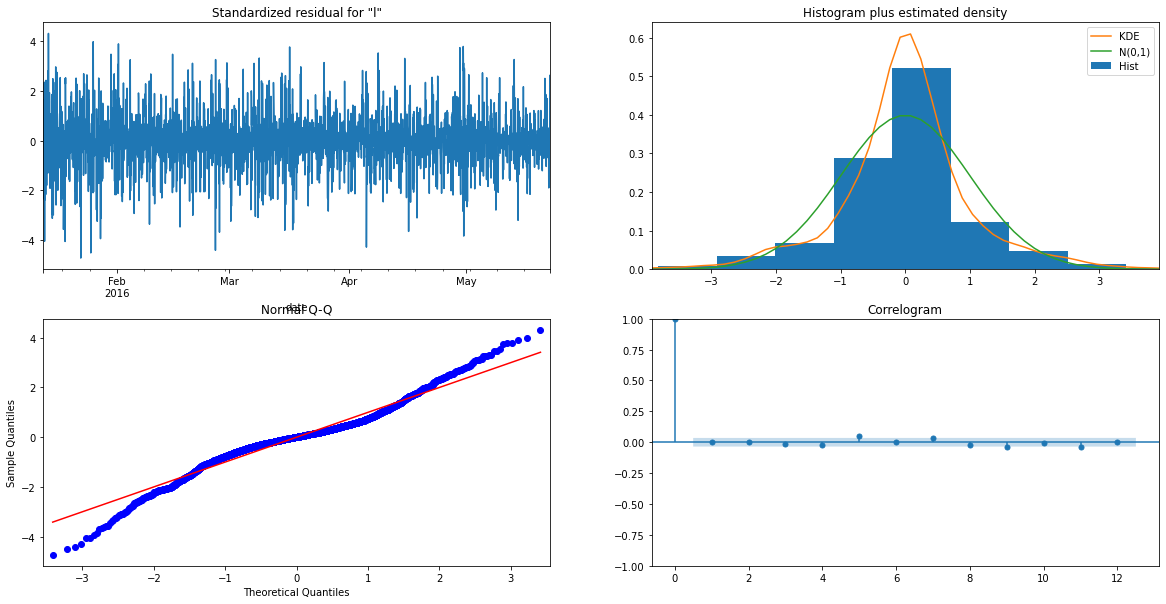

In [32]:
sar1.plot_diagnostics(lags=12,figsize = (20,10));

#### Plot Forecasting

In [33]:
## No of days to predict the future (test size)
horizon = 120 

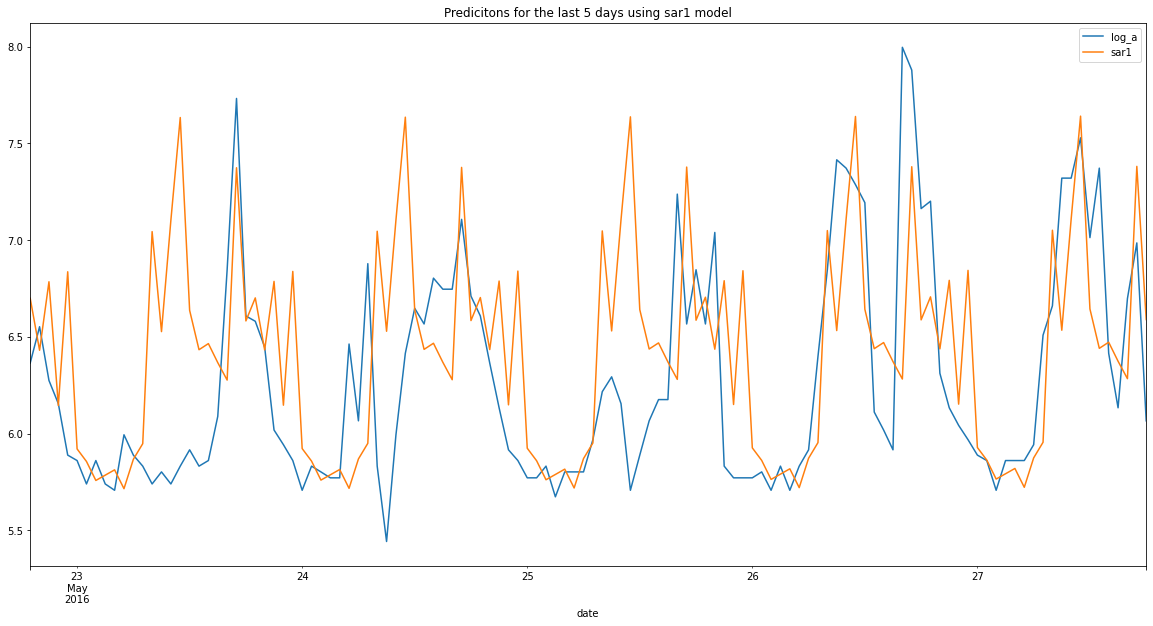

In [34]:
df_B['sar1'] = sar1.forecast(steps = horizon)
df_B[-horizon:][['log_a', 'sar1']].plot(figsize=(20,10), title='Predicitons for the last 5 days using sar1 model');

> One can see that the Model 1(sar1) does a pretty good job in predicting for the last 5 days in May. It is able to capture the peaks quite well, which could also mean a slight overfitting. But it also overestimates the consumption values during the forenoon periods on the 23rd and 25th.

#### Error metric

In [35]:
mape('sar1',120)

The mean error for Model sar1 is : 0.0666


### Model 2 : Sarimax (2,0,0)(0,1,5,24)
Since from the ACF plot, it was indicated that q should be 5, for this model q=2. Other parameters remain same as in model. 
Seasonality = 24 hours.

In [36]:
sar2 = sm.tsa.statespace.SARIMAX(y_train, 
                                order=(2,0,0), 
                                seasonal_order=(0,1,5,24), 
                                trend='c').fit()

In [37]:
sar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            SARIMAX Results                                             
========================================================================================================
Dep. Variable:                                            log_a   No. Observations:                 3163
Model:             SARIMAX(2, 0, 0)x(0, 1, [1, 2, 3, 4, 5], 24)   Log Likelihood               -1558.511
Date:                                          Fri, 21 May 2021   AIC                           3135.022
Time:                                                  10:36:32   BIC                           3189.487
Sample:                                              01-12-2016   HQIC                          3154.568
                                                   - 05-22-2016                                         
Covariance Type:                                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.723      0.470      -0.000       0.001
ar.L1          0.4582      0.014     32.715      0.000       0.431       0.486
ar.L2          0.2164      0.014     15.524      0.000       0.189       0.244
ma.S.L24      -0.8912      0.014    -62.020      0.000      -0.919      -0.863
ma.S.L48      -0.0888      0.019     -4.632      0.000      -0.126      -0.051
ma.S.L72       0.0199      0.020      0.985      0.325      -0.020       0.060
ma.S.L96      -0.0321      0.019     -1.687      0.092      -0.069       0.005
ma.S.L120      0.0052      0.015      0.348      0.728      -0.024       0.035
sigma2         0.1538      0.003     54.128      0.000       0.148       0.159
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               910.90
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> __AIC score = 3135.022__

#### Plot residuals

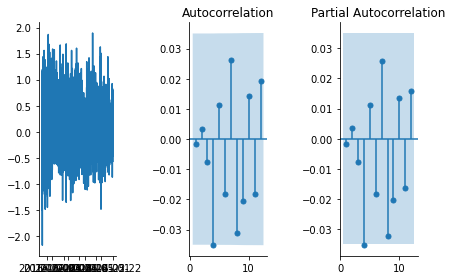

In [38]:
plots(sar2.resid[sar2.loglikelihood_burn:],lags=12);

#### Plot residual diagnostics

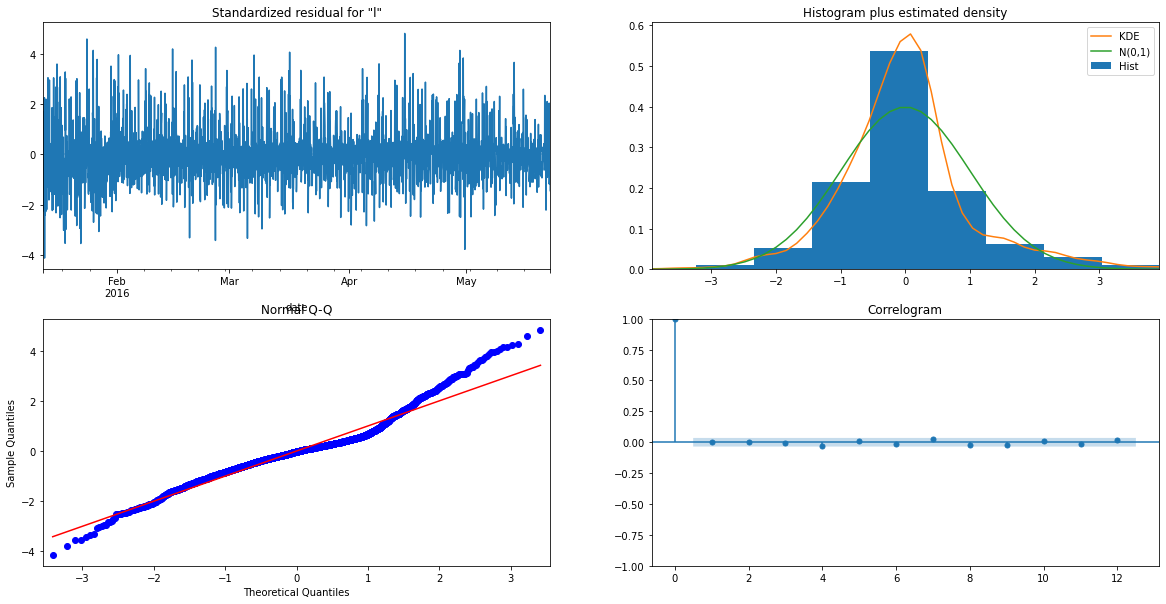

In [39]:
sar2.plot_diagnostics(lags=12,figsize = (20,10));

> Here the distribution seems to be more normal and the AIC and BIC values are lower than model 1

#### Plot Forecasting

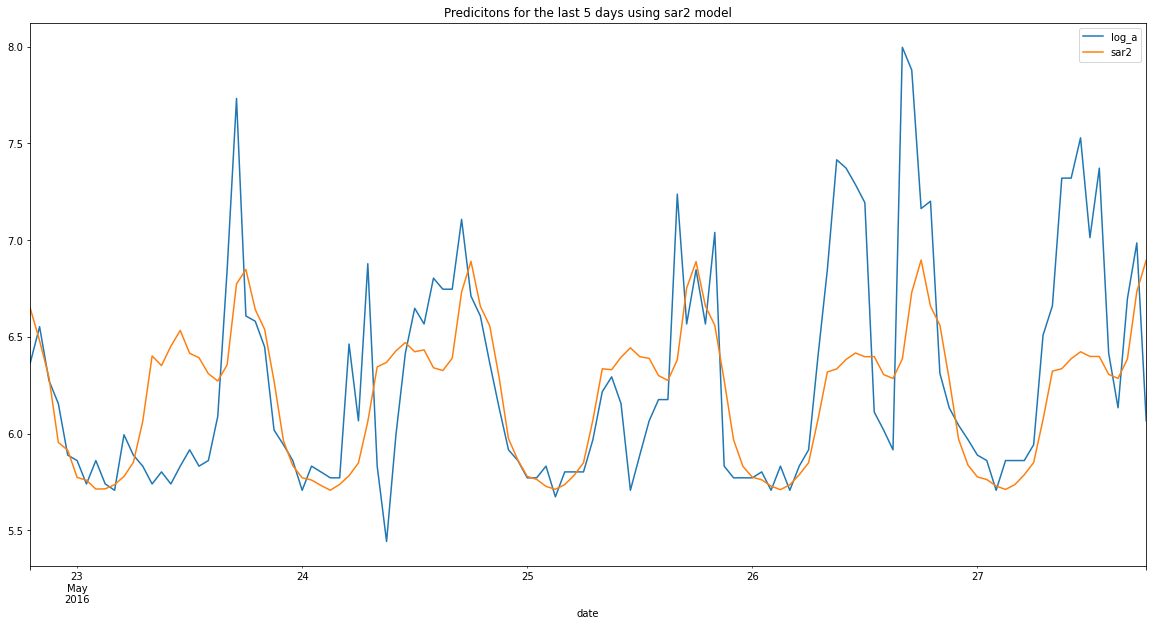

In [40]:
df_B['sar2'] = sar2.forecast(steps = horizon)
df_B[-horizon:][['log_a', 'sar2']].plot(figsize=(20,10),title='Predicitons for the last 5 days using sar2 model');

> We see that Model 2 (sar2) gives a smoother curve than Model 1. This could mean less overfitting. But it is unable to capture the fine fluctuations in the peaks and gives a more average value.

#### Error metric

In [41]:
mape('sar2',120)

The mean error for Model sar2 is : 0.0493


### Model 3 : Sarimax (autoarima)
The autoaroma model is run to find the best model with optimum parameters - minimum AIC value. 

In [42]:
stepwise_model = pm.auto_arima(y_train, start_p=1, start_q=1,
                           max_p=3, max_q=5, m=24,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=39.35 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=6114.902, Time=1.77 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=4337.714, Time=11.03 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=27.19 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=6112.961, Time=0.96 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=5024.126, Time=5.95 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=3968.075, Time=27.67 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=93.04 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=32.38 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=5261.671, Time=21.79 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=3792.163, Time=35.79 sec
 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=4152.017, Time=10.44 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=110.30 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=34.82 sec
 ARIMA(3,0,0)(2,1,0)[24] intercept   

> __AIC score = 3790.17__

#### Plot residual diagnostics

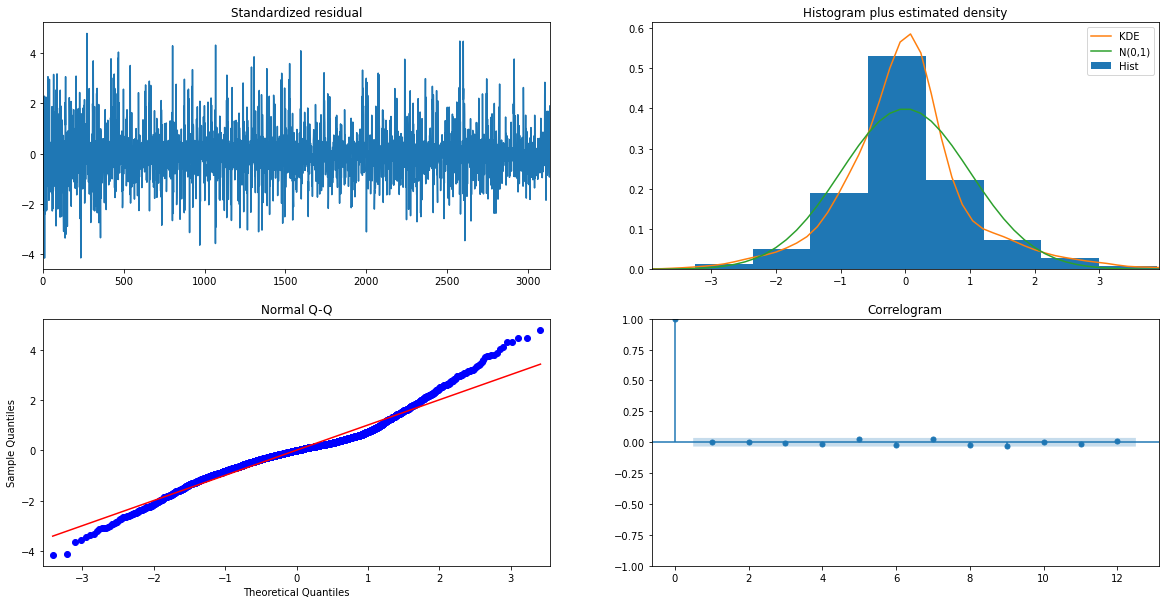

In [43]:
stepwise_model.plot_diagnostics(lags=12,figsize = (20,10));

#### Autoarima Model parameters

In [44]:
print('auto-fit order: :', stepwise_model.order)
print('auto-fit seasonal_order: :', stepwise_model.seasonal_order)

auto-fit order: : (2, 0, 0)
auto-fit seasonal_order: : (2, 1, 0, 24)


#### Plot Forecasting

In [45]:
df_B['auto_arima'] = future_preds_df(stepwise_model,y_train,120)

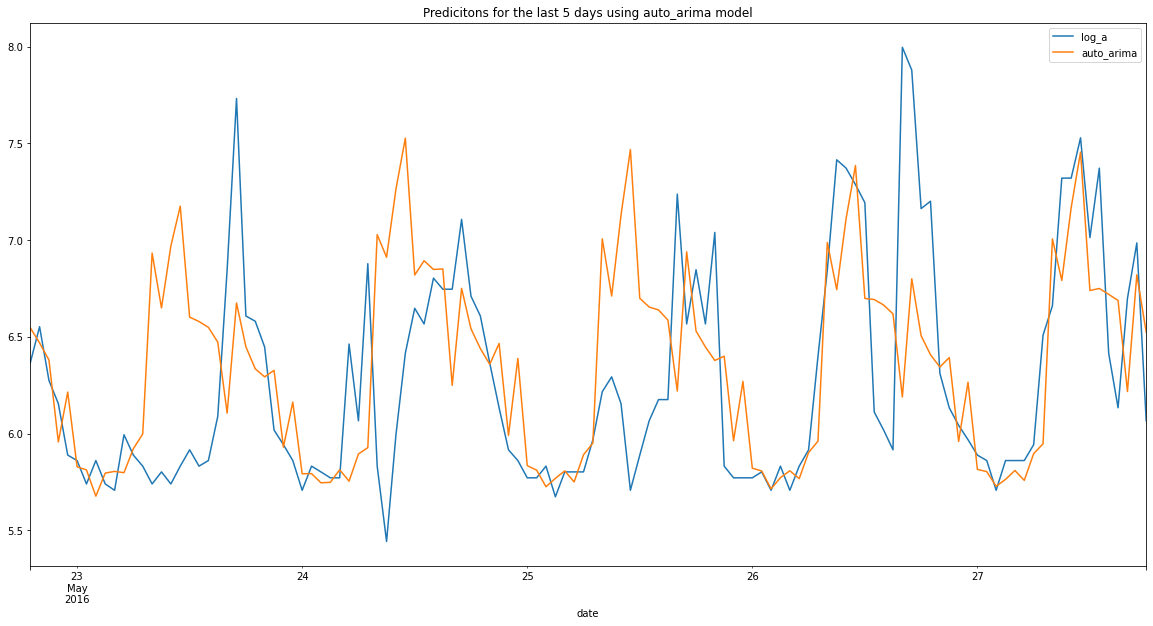

In [46]:
df_B[-horizon:][['log_a','auto_arima']].plot(figsize=(20,10),title='Predicitons for the last 5 days using auto_arima model');

> Autoarima's best model, like Model 1 overestimates the values during the forenoon periods on the 23rd and 25th. But unlike Model 1, it is unable to match the peaks and fluctuations less accurately.

#### Error metric

In [47]:
mape('auto_arima',120)

The mean error for Model auto_arima is : 0.0618


### Best Model

In [48]:
df_B.tail()

,Appliances,log_a,lag_24,seasonal_diff,sar1,sar2,auto_arima
date,,,,,,,
2016-05-27 14:00:00,610,6.42,6.02,0.40,6.47,6.31,6.72
2016-05-27 15:00:00,460,6.13,5.92,0.22,6.37,6.29,6.69
2016-05-27 16:00:00,810,6.70,8.00,-1.30,6.28,6.39,6.22
2016-05-27 17:00:00,1080,6.99,7.88,-0.89,7.38,6.73,6.82
2016-05-27 18:00:00,430,6.07,7.16,-1.10,6.59,6.90,6.52


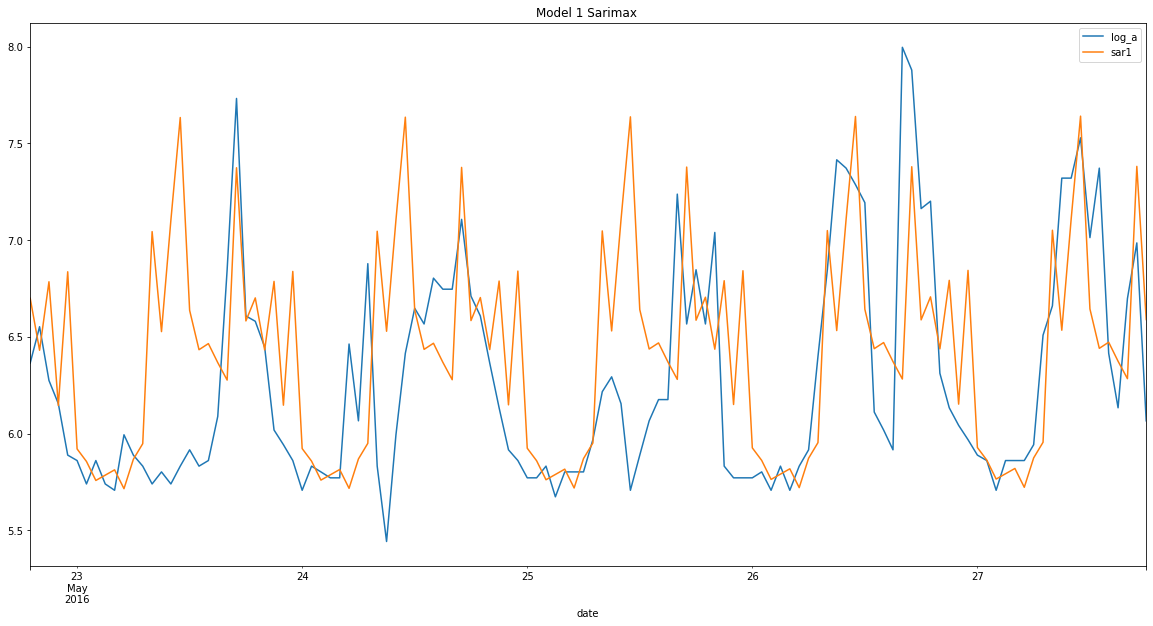

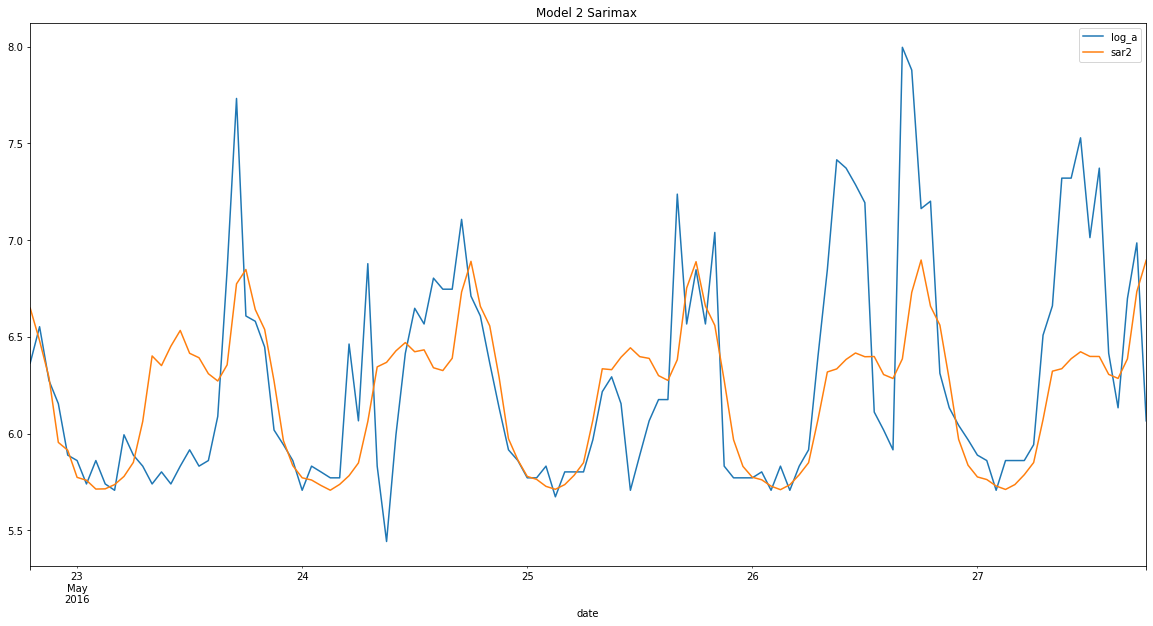

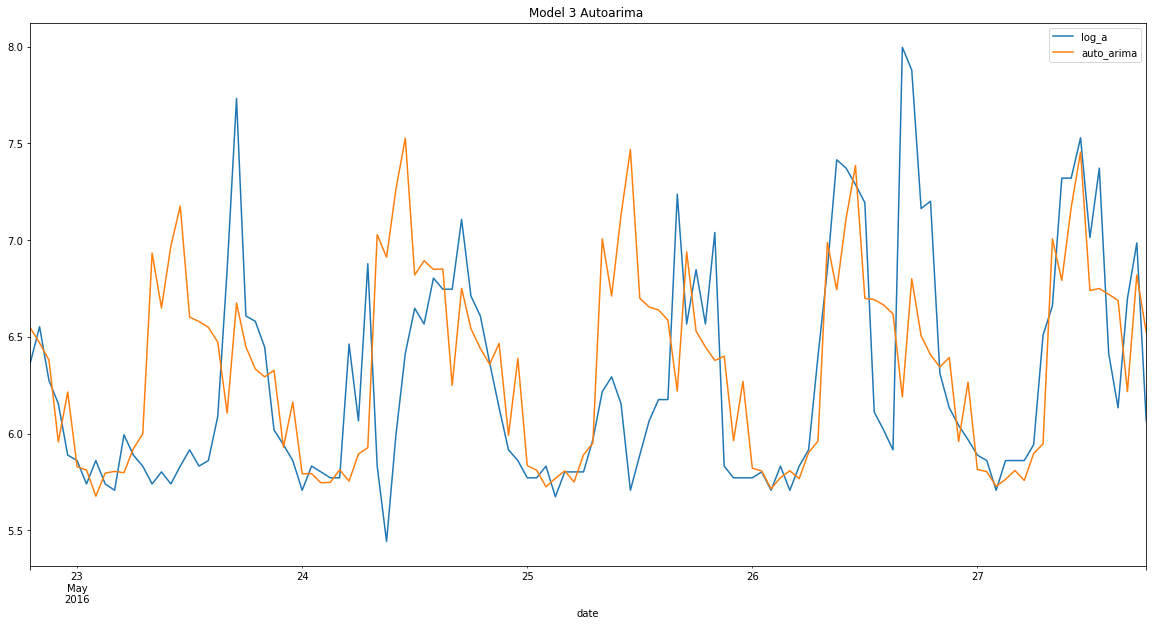

In [49]:
df_B[-horizon:][['log_a','sar1']].plot(figsize=(20,10),title='Model 1 Sarimax ')
df_B[-horizon:][['log_a','sar2']].plot(figsize=(20,10),title='Model 2 Sarimax ')
df_B[-horizon:][['log_a','auto_arima']].plot(figsize=(20,10),title='Model 3 Autoarima ');

> From the error metrics, Model 1 has the highest mean error values of __0.0666__.   

> Based on the plot comparison above, one can see however that Model 1 among all matches the energy curve patterns more accurately. Although it overestimates a little, in my opinion that is safer than underestimating the energy consumption values.

Hence based on these observations, __Model 1 Sarimax (2,0,0)(0,1,0,24)__ would be my model of choice here

In [50]:
sar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              log_a   No. Observations:                 3163
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 24)   Log Likelihood               -2422.702
Date:                            Fri, 21 May 2021   AIC                           4853.403
Time:                                    10:48:50   BIC                           4877.610
Sample:                                01-12-2016   HQIC                          4862.090
                                     - 05-22-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.009      0.068      0.946      -0.018       0.019
ar.L1          0.4171      0.013     32.343      0.000       0.392       0.442
ar.L2          0.2317      0.013     17.338      0.000       0.205       0.258
sigma2         0.2741      0.005     57.500      0.000       0.265       0.283
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               701.13
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""